In [ ]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
# from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Lambda, Dense, Dropout, concatenate
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

import matplotlib.pyplot as plt
import ast
import pickle
import gc



def load_embeddings(file_path):
    with open(file_path, "rb") as f:
        data = pickle.load(f)
    # Reduce precision to float16 to save memory
    return {k: np.array(v, dtype=np.float16) for k, v in data.items()}

def generate_dataset(df_path, embedding_map):
    df = pd.read_csv(df_path)

    # Only keep required columns and drop the rest
    df = df[['sentence1_clean', 'sentence2_clean', 'score']]

    # Use map with memory-efficient data types
    df['sentence1_embedding'] = df['sentence1_clean'].map(embedding_map)
    df['sentence2_embedding'] = df['sentence2_clean'].map(embedding_map)

    # Convert to float16 arrays (RAM-efficient)
    X1 = np.stack(df['sentence1_embedding'].values).astype(np.float16)
    X2 = np.stack(df['sentence2_embedding'].values).astype(np.float16)
    y = df['score'].astype(np.float16).values

    return X1, X2, y

def build_model(input_shape):
    input1 = Input(shape=input_shape)
    input2 = Input(shape=input_shape)

    shared_rnn = Bidirectional(LSTM(64, return_sequences=False))

    encoded1 = shared_rnn(input1)
    encoded2 = shared_rnn(input2)

    abs_diff = Lambda(lambda x: tf.abs(x[0] - x[1]))([encoded1, encoded2])
    mult = Lambda(lambda x: x[0] * x[1])([encoded1, encoded2])

    merged = concatenate([encoded1, encoded2, abs_diff, mult])
    dense = Dense(128, activation='relu')(merged)
    drop = Dropout(0.3)(dense)
    output = Dense(1, activation='linear')(drop)

    model = Model(inputs=[input1, input2], outputs=output)
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return model

from google.colab import drive
drive.mount('/content/drive/')

max_len = 30
sentence_to_embedding = load_embeddings("drive/MyDrive/MACHINE PROJECT/sentence_to_embedding.pkl")

sample_embedding = next(iter(sentence_to_embedding.values()))
embedding_dim = sample_embedding.shape[1] if sample_embedding.ndim == 2 else sample_embedding.shape[0]
X1, X2, y = generate_dataset("drive/MyDrive/MACHINE PROJECT/rs2_augmented.csv", sentence_to_embedding)

# Clean up large variables no longer needed
del sentence_to_embedding
gc.collect()

# Train-test split
X1_train, X1_val, X2_train, X2_val, y_train, y_val = train_test_split(
    X1, X2, y, test_size=0.2, random_state=42
)

del X1, X2, y
gc.collect()

model = build_model((max_len, embedding_dim))

history = model.fit(
    [X1_train, X2_train], y_train,
    validation_data=([X1_val, X2_val], y_val),
    epochs=10, batch_size=16  # Reduce batch size to save RAM
)

y_pred = model.predict([X1_val, X2_val], batch_size=16).flatten()



Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Epoch 1/10
24142/24142 ━━━━━━━━━━━━━━━━━━━━ 570s 23ms/step - loss: 1.0521 - mae: 0.7967 - val_loss: 0.4185 - val_mae: 0.4895
Epoch 2/10
24142/24142 ━━━━━━━━━━━━━━━━━━━━ 532s 22ms/step - loss: 0.3718 - mae: 0.4677 - val_loss: 0.2701 - val_mae: 0.3884
Epoch 3/10
24142/24142 ━━━━━━━━━━━━━━━━━━━━ 532s 22ms/step - loss: 0.2494 - mae: 0.3837 - val_loss: 0.2102 - val_mae: 0.3386
Epoch 4/10
24142/24142 ━━━━━━━━━━━━━━━━━━━━ 533s 22ms/step - loss: 0.1918 - mae: 0.3364 - val_loss: 0.1757 - val_mae: 0.3083
Epoch 5/10
24142/24142 ━━━━━━━━━━━━━━━━━━━━ 532s 22ms/step - loss: 0.1581 - mae: 0.3061 - val_loss: 0.1511 - val_mae: 0.2852
Epoch 6/10
24142/24142 ━━━━━━━━━━━━━━━━━━━━ 532s 22ms/step - loss: 0.1357 - mae: 0.2836 - val_loss: 0.1392 - val_mae: 0.2735
Epoch 7/10
24142/24142 ━━━━━━━━━━━━━━━━━━━━ 532s 22ms/step - loss: 0.1230 - mae: 0.2699 - val_loss: 0.1273 - val_mae: 0

In [ ]:
from scipy.stats import pearsonr, spearmanr

📈 Pearson Correlation:  0.9764
📊 Spearman Correlation: 0.9751


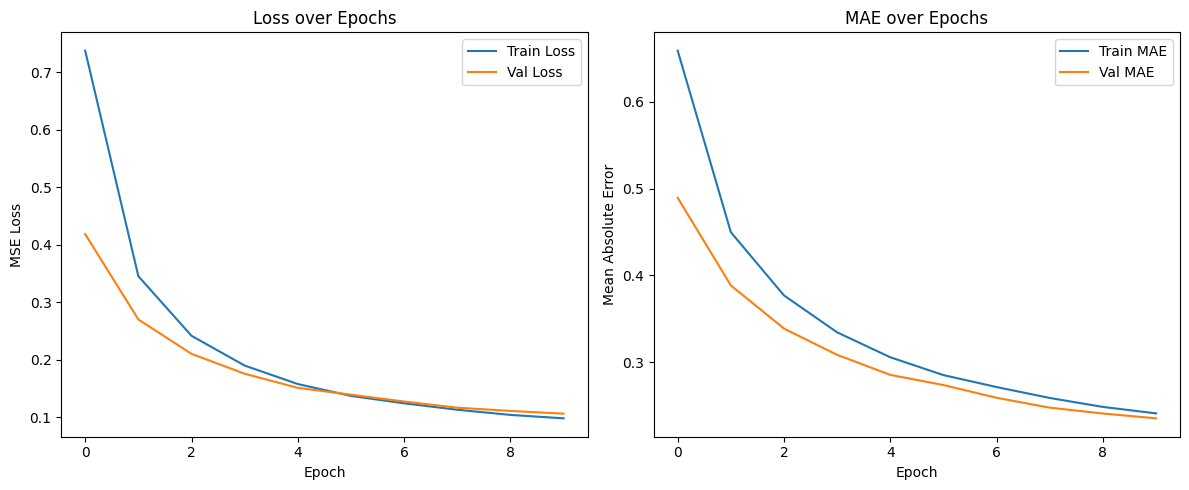

In [ ]:
pearson_corr, _ = pearsonr(y_val, y_pred)
spearman_corr, _ = spearmanr(y_val, y_pred)

print(f"📈 Pearson Correlation:  {pearson_corr:.4f}")
print(f"📊 Spearman Correlation: {spearman_corr:.4f}")

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

# Helper function
def evaluate(y_true, y_pred):
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "MAPE": mean_absolute_percentage_error(y_true, y_pred),
        "R²": r2_score(y_true, y_pred)
    }


print(evaluate(y_val, y_pred))

{'MSE': 0.10620544105768204, 'MAE': 0.23506881296634674, 'MAPE': 71905352613888.0, 'R²': 0.9518745541572571}
